In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.0 MB/s eta 0:00:00


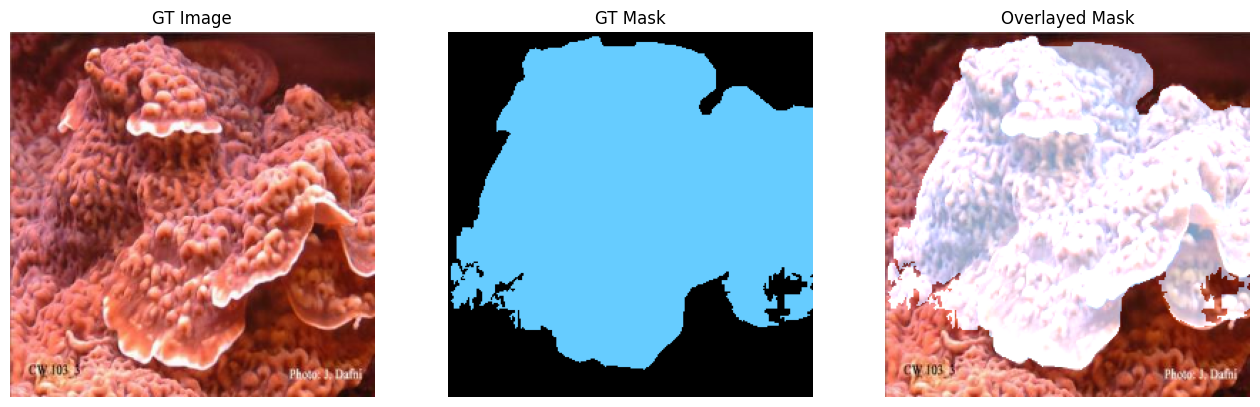

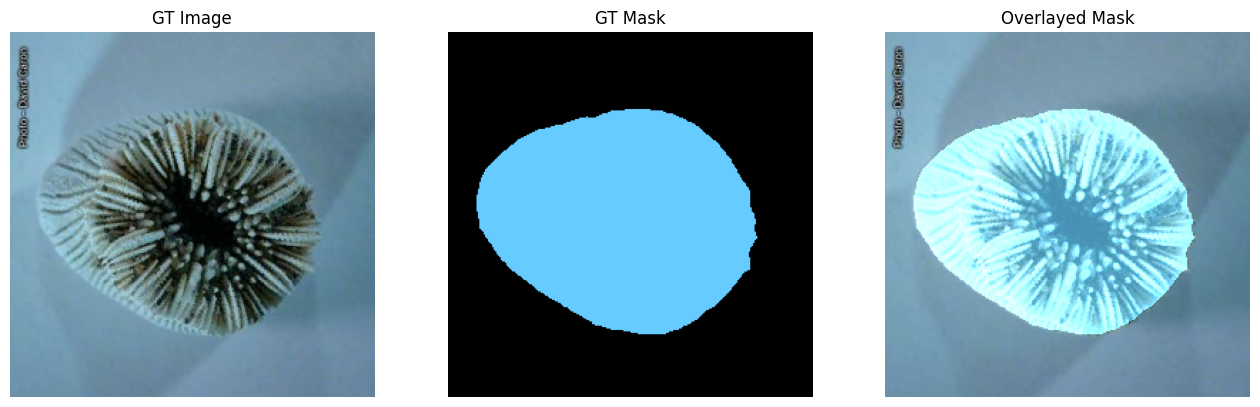

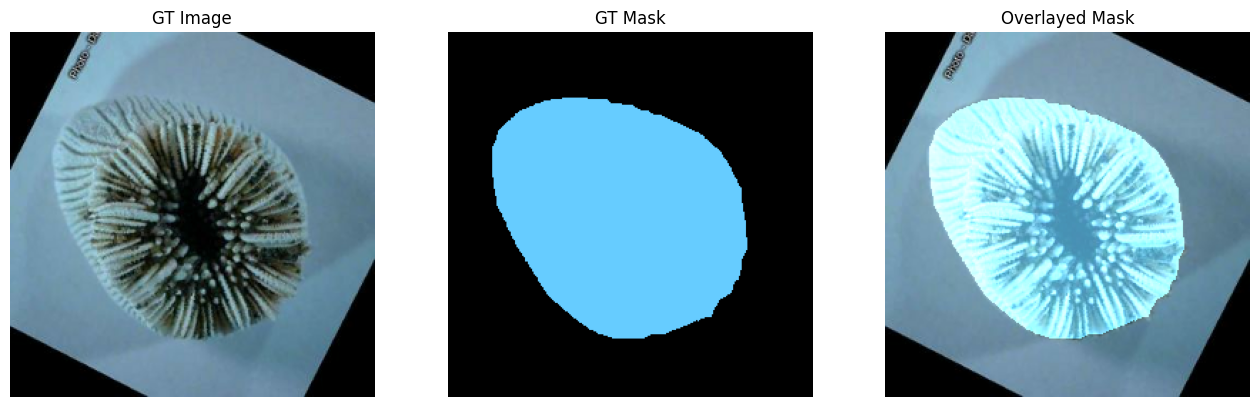

In [3]:
import os
import random
import glob
import numpy as np
import tensorflow as tf
from dataclasses import dataclass
import cv2
import matplotlib.pyplot as plt

# Set random seed for reproducibility
def system_config(SEED_VALUE):
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)

@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE: tuple = (256, 256)
    BATCH_SIZE: int = 16
    NUM_CLASSES: int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR: float = 0.2

@dataclass(frozen=True)
class TrainingConfig:
    MODEL: str = "resnet50_v2_imagenet"
    EPOCHS: int = 100
    LEARNING_RATE: float = 1e-4
    CKPT_DIR: str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]),
                                 "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".weights.h5")
    LOGS_DIR: str = "logs_"+"_".join(MODEL.split("_")[:2])

# Instantiate configuration
data_config = DatasetConfig()
train_config = TrainingConfig()

# Define dataset directories
DATASET_DIR = "/content/drive/MyDrive/dataset"
train_images = glob.glob(os.path.join(DATASET_DIR, "train_images", "*.jpg"))
train_masks = glob.glob(os.path.join(DATASET_DIR, "train_masks", "*.jpg"))
valid_images = glob.glob(os.path.join(DATASET_DIR, "valid_images", "*.jpg"))
valid_masks = glob.glob(os.path.join(DATASET_DIR, "valid_masks", "*.jpg"))

# Ensure the lists are sorted to keep the pairs in sync
train_images.sort()
train_masks.sort()
valid_images.sort()
valid_masks.sort()

def read_image_mask(image_path, mask=False, size=data_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.io.decode_image(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method="bicubic")

        image_mask = tf.zeros_like(image)
        cond = image >= 200
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)
    else:
        image = tf.io.decode_image(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method="bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)
    return image

def load_data(image_path, mask_path):
    image = read_image_mask(image_path)
    mask = read_image_mask(mask_path, mask=True)
    return {"images": image, "segmentation_masks": mask}

train_data = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
valid_data = tf.data.Dataset.from_tensor_slices((valid_images, valid_masks))

train_ds = train_data.map(lambda image, mask: load_data(image, mask), num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(lambda image, mask: load_data(image, mask), num_parallel_calls=tf.data.AUTOTUNE)

def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

id2color = {
    0: (0, 0, 0),  # Background
    1: (102, 204, 255),  # Waterbodies
}

def num_to_rgb(num_arr, color_map=id2color):
    output = np.zeros(num_arr.shape[:2] + (3,))
    for k in color_map.keys():
        output[num_arr == k] = color_map[k]
    return output.astype(np.uint8)

def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    image = image.astype(np.uint8)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list) == 3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")
        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")
        else:
            axis.imshow(data_list[idx])
        axis.axis('off')

    plt.show()

# Plot a batch of images and masks to verify correct mapping
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=True)

In [4]:
import keras_cv
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

Using TensorFlow backend


In [7]:
train_dataset = (
                train_ds.shuffle(data_config.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [8]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = train_config.MODEL,
                                                          input_shape=data_config.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=data_config.NUM_CLASSES, backbone=backbone,
    )
print(model.summary())

100%|██████████| 886/886 [00:00<00:00, 1.33MB/s]
100%|██████████| 90.3M/90.3M [00:02<00:00, 46.3MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "deep_lab_v3_plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          {'P2': (None, 64, 64, 256)   2355660   ['input_1[0][0]']             
                             , 'P5': (None, 8, 8, 2048)   8                                       
                             }                                                                    
                                                                                                  
 spatial_pyramid_pooling (S  (None, 8, 8, 256)            1553817   ['model[0][1]']               
 patialPyramidPooling)                                    6                        

In [9]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

In [19]:
# Define callbacks including early stopping and model checkpoint
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=False,
    patience=10
):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )

    checkpoint_dir = "/content/drive/MyDrive/models"

    checkpoint_filepath = os.path.join(checkpoint_dir, train_config.CKPT_DIR) if save_weights_only else train_config.CKPT_DIR.replace(".weights.h5", ".h5")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        verbose=1,
        mode=mode,
        restore_best_weights=True
    )

    return [tensorboard_callback, model_checkpoint_callback, early_stopping_callback]


In [20]:
# Get callbacks.
callbacks = get_callbacks(train_config)
# Define Loss.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Compile model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou],
)

In [21]:
# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


78/78 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9649 - mean_iou: 0.8954
Epoch 1: saving model to /content/drive/MyDrive/models/checkpoints_resnet50_v2/deeplabv3_plus_resnet50_v2.weights.h5
78/78 [==============================] - 63s 469ms/step - loss: 0.0880 - accuracy: 0.9649 - mean_iou: 0.8954 - val_loss: 0.3666 - val_accuracy: 0.8986 - val_mean_iou: 0.7736
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9658 - mean_iou: 0.8999
Epoch 2: saving model to /content/drive/MyDrive/models/checkpoints_resnet50_v2/deeplabv3_plus_resnet50_v2.weights.h5
78/78 [==============================] - 38s 468ms/step - loss: 0.0886 - accuracy: 0.9658 - mean_iou: 0.8999 - val_loss: 0.2958 - val_accuracy: 0.9206 - val_mean_iou: 0.8014
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9672 - mean_iou: 0.9026
Epoch 3: saving model to /content/drive/MyDrive/models/checkpoints_resnet50_v2/deeplabv3

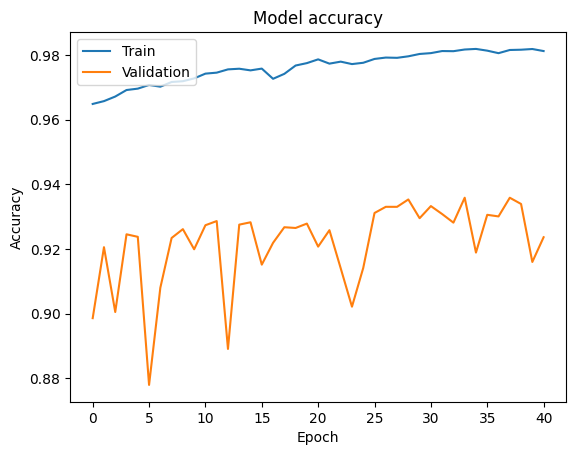

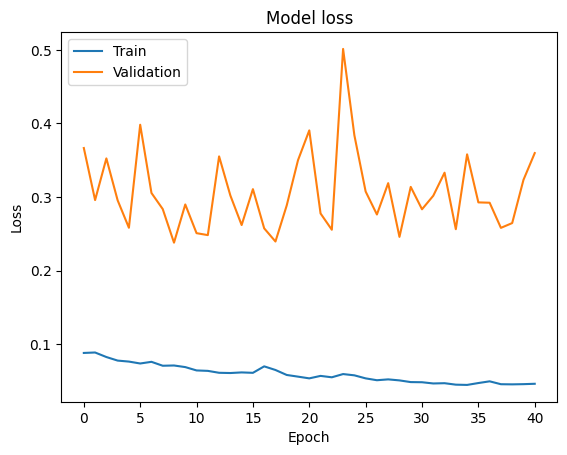

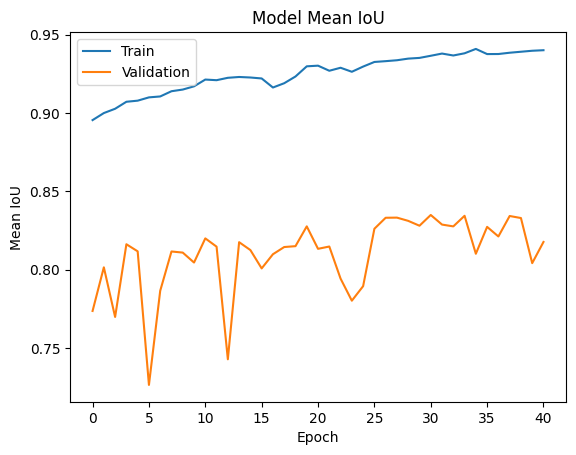

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



# Plot training & validation mean IoU values
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('Model Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
